# Chest X-Ray Image Using EfficientNet

[Dwv with Yao](https://www.youtube.com/watch?v=012xnlwY3G4)

## Get the Dataset

In [ ]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod +600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:25<00:00, 92.8MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.0MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Import modules

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import torch
import os

## Create basic function

In [ ]:
def show_image(image, label, get_denormalize=True):
  image = image.permute(1, 2, 0)
  mean = torch.FloatTensor([0.485, 0.456, 0.406])
  std = torch.FloatTensor([0.299, 0.224, 0.225])

  if get_denormalize == True:
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(label)
  else:
    plt.imshow(image)
    plt.title(label)


def show_grid(image, title=None):
  image = image.permute(1,2,0)
  mean = torch.FloatTensor([0.485, 0.456, 0.406])
  std = torch.FloatTensor([0.229, 0.224, 0.225])

  image = image*std + mean
  image = np.clip(image, 0, 1)

  plt.figure(figsize=[15, 15])
  plt.imshow(image)
  if title != None:
    plt.title(title)


def accuracy(y_pred, y_true):
  y_pred = F.softmax(y_pred, dim=1)
  top_p, top_class = y_pred.topk(1, dim=1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image, ps, label):
  class_name = ["NORMAL", "PNEUMONIA"]
  classes = np.array(class_name)

  ps = ps.cpu().data.numpy().squeeze()

  image = image.permute(1,2,0)
  mean = torch.FloatTensor([0.485, 0.456, 0.406])
  std = torch.FloatTensor([0.229, 0.224, 0.225])

  image = image * std + mean
  image = np.clip(image, 0, 1)

  fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
  ax1.imshow(img)
  ax1.set_title("Ground Truth: {}".format(class_name[label]))
  ax1.axis('off')
  ax2.barh(classes, ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(classes)
  ax2.set_yticklabels(classes)
  ax2.set_title("Predicted Class")
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

  return None

In [ ]:
class CFG:

    epochs=5
    lr = 0.001
    batch_size = 16

    model_name = 'tf_efficientnet_b4_ns'
    img_size = 224

    # Going to use te dataset
    train_path = '/content/chest_xray/chest_xray/train'
    validate_path = '/content/chest_xray/chest_xray/val'
    test_path = '/content/chest_xray/chest_xray/test'

    # This two below must not inside the class, but if follow this notebook, it must be followed in order
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We are using: {}".format(device))

We are using: cuda


In [ ]:
from torchvision import transforms as T, datasets

In [ ]:
train_transform = T.Compose([
                             T.Resize(size=(CFG.img_size, CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20, +20)), # Rotate image randomly +/- 20 degrees 
                             T.ToTensor(), # Converting dimension from (height, weight, channel) to (channel, height, weight)
                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Noramlize by 3 means 3 StD's of the image net, 3 channels
])

validate_transform = T.Compose([
                             T.Resize(size=(CFG.img_size, CFG.img_size)),
                             # T.RandomRotation(degrees=(-20, +20)),
                             T.ToTensor(),
                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
                             T.Resize(size=(CFG.img_size, CFG.img_size)),
                             # T.RandomRotation(degrees=(-20, +20)),
                             T.ToTensor(),
                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
trainset = datasets.ImageFolder(CFG.train_path, transform=train_transform)
print("Trainset Size: {}".format(len(trainset)))

Trainset Size: 5216


In [ ]:
validateset = datasets.ImageFolder(CFG.validate_path, transform=validate_transform)
print("Validateset Size: {}".format(len(validateset)))

Validateset Size: 16


In [ ]:
testset = datasets.ImageFolder(CFG.test_path, transform=test_transform)
print("Testset Size: {}".format(len(testset)))

Testset Size: 624


{'NORMAL': 0, 'PNEUMONIA': 1}


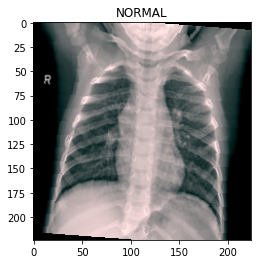

In [ ]:
img, label = trainset[20]
print(trainset.class_to_idx)

class_name = ['NORMAL', 'PNEUMONIA']
show_image(img, class_name[label])

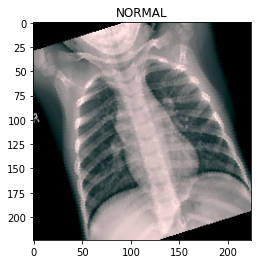

In [ ]:
img, label = trainset[20]
# print(trainset.class_to_idx)

class_name = ['NORMAL', 'PNEUMONIA']
show_image(img, class_name[label])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainLoader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)
print("No. of batches in trainLoader: {}".format(len(trainLoader))) # Trainset Size: 5216/ batch_size: 16 = 326 (No of batches)
print("No. of Total Examples: {}".format(len(trainLoader.dataset)))

No. of batches in trainLoader: 326
No. of Total Examples: 5216


In [ ]:
validationLoader = DataLoader(validateset, batch_size=CFG.batch_size, shuffle=True)
print("No. of batches in validationLoader: {}".format(len(validationLoader))) # validateset Size: 5216/ batch_size: 16 = 326 (No of batches)
print("No. of Total Examples: {}".format(len(validationLoader.dataset)))

No. of batches in validationLoader: 1
No. of Total Examples: 16


In [ ]:
testLoader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)
print("No. of batches in testLoader: {}".format(len(testLoader))) # testset Size: 5216/ batch_size: 16 = 326 (No of batches)
print("No. of Total Examples: {}".format(len(testLoader.dataset)))

No. of batches in testLoader: 39
No. of Total Examples: 624


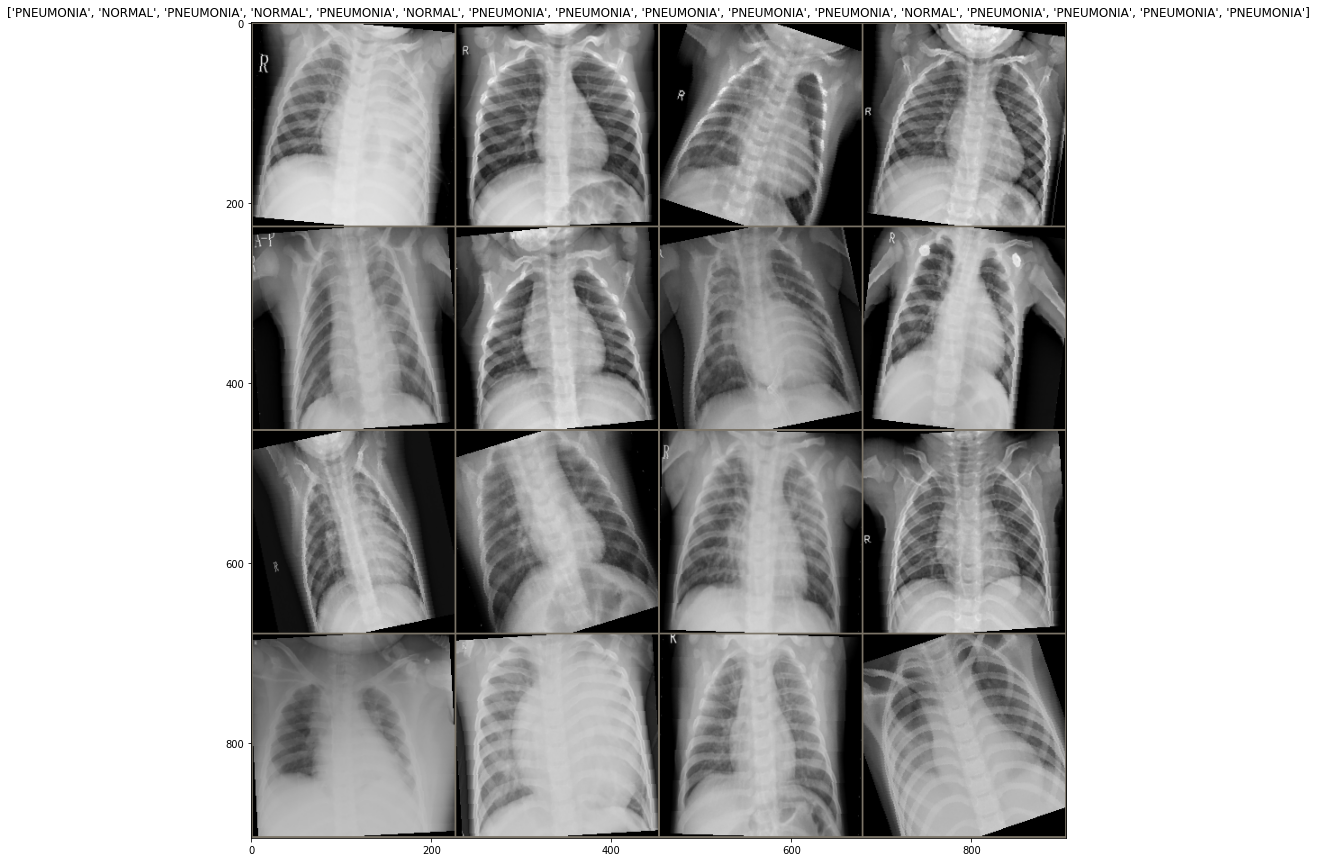

In [ ]:
dataiter = iter(trainLoader)
images, labels = dataiter.next()

out = make_grid(images, nrow=4)

show_grid(out, title=[class_name[x] for x in labels])

In [ ]:
!pip install timm # Install PyTorch image models

     |████████████████████████████████| 376 kB 5.3 MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm 

model = timm.create_model(CFG.model_name, pretrained=True)

In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [ ]:
# Updating pretrained model
for param in model.parameters():
  param.requires_grad=False

# Original
# (classifier): Linear(in_features=1792, out_features=1000, bias=True)

# Update into 2-class classifier
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), # 1792 is the orignal in features
    nn.ReLU(), # activation function
    nn.Dropout(),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
)

model

# After updating it becomes:
# (clasifier): Sequential(
#     (0): Linear(in_features=1792, out_features=625), # 1792 is the orignal in features
#     (1): ReLU(), # activation function
#     (2): Dropout(),
#     (3): Linear(in_features=625, out_features=256),
#     (4): ReLU(),
#     (5): Linear(in_features=256, out_features=2)
# )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [ ]:
from torchsummary import summary
model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

In [ ]:
class PneumoniaTrainer():

  def __init__(self, criterion=None, optimizer=None, schedular=None):
    self.criterion = criterion
    self.optimizer = optimizer
    self.schedular = schedular

  def train_batch_loop(self, model, trainLoader):
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in tqdm(trainLoader):
      # Move data to CPU
      images = images.to(device)
      labels = labels.to(device)

      logits = model(images)
      loss = self.criterion(logits, labels)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      train_loss += loss.item()
      train_acc += accuracy(logits, labels)

    return train_loss / len(trainLoader), train_acc / len(trainLoader)


  def valid_batch_loop(self, model, validationLoader):
    valid_loss = 0.0
    valid_acc = 0.0

    for images, labels in tqdm(validationLoader):
      # Move data to CPU
      images = images.to(device)
      labels = labels.to(device)

      logits = model(images)
      loss = self.criterion(logits, labels)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      valid_loss += loss.item()
      valid_acc += accuracy(logits, labels)

    return valid_loss / len(validationLoader), valid_acc / len(validationLoader)

    
  def fit(self, model, trainLoader, validationLoader, epochs):
    valid_min_loss = np.Inf

    for i in range(epochs):
      model.train()
      avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainLoader)

      model.eval()
      avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validationLoader)

      if avg_valid_loss <= valid_min_loss:
        print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
        torch.save(model.state_dict(), 'ColabPneumoniaModel.pt')
        valid_min_loss = avg_valid_loss

      print("Epoch: {} Train Loss: {:.6f} Train Acc: {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
      print("Epoch: {} Valid Loss: {:.6f} Valid Acc: {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

trainer = PneumoniaTrainer(criterion, optimizer)
trainer.fit(model, trainLoader, validationLoader, epochs=CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased inf --> 0.6671032309532166
Epoch: 1 Train Loss: 0.266059 Train Acc: 0.889762
Epoch: 1 Valid Loss: 0.667103 Valid Acc: 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased 0.6671032309532166 --> 0.41042348742485046
Epoch: 2 Train Loss: 0.214259 Train Acc: 0.916028
Epoch: 2 Valid Loss: 0.410423 Valid Acc: 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased 0.41042348742485046 --> 0.396756112575531
Epoch: 3 Train Loss: 0.207342 Train Acc: 0.920629
Epoch: 3 Valid Loss: 0.396756 Valid Acc: 0.812500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased 0.396756112575531 --> 0.3405058979988098
Epoch: 4 Train Loss: 0.193144 Train Acc: 0.922738
Epoch: 4 Valid Loss: 0.340506 Valid Acc: 0.875000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.183067 Train Acc: 0.924655
Epoch: 5 Valid Loss: 0.482823 Valid Acc: 0.750000


In [ ]:
model.load_state_dict(torch.load("/content/ColabPneumoniaModel.pt"))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model, testLoader)

print("Test Loss: {}".format(avg_test_loss))
print("Test Acc: {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss: 0.294140733873997
Test Acc: 0.8717948794364929


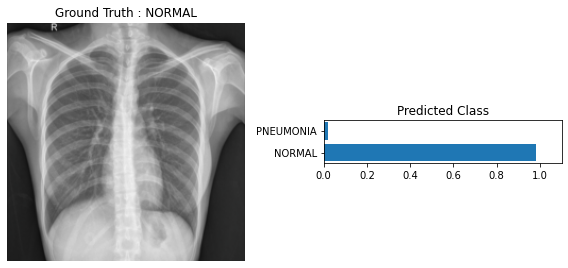

In [ ]:
image, label = testset[27]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim=1)

view_classify(image, ps, label)

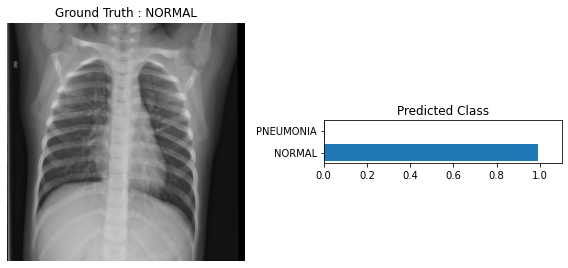

In [ ]:
image, label = testset[90]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim=1)

view_classify(image, ps, label)

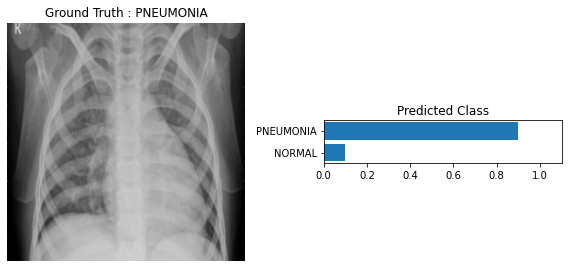

In [ ]:
image, label = testset[500]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim=1)

view_classify(image, ps, label)